# Описание проекта

**Задача**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
      1) выделить целевые группы клиентов;
      2) предложить меры по снижению оттока;
      3) определить другие особенности взаимодействия с клиентами.
  

# Описание данных
**Данные клиента за предыдущий до проверки факта оттока месяц:**

   - 'gender' — пол;
   - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
   - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на бонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
   - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
   - 'Phone' — наличие контактного телефона;
   - 'Age' — возраст;
   - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
   
**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**

   - 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
   - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
   - 'Group_visits' — факт посещения групповых занятий;
   - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
   - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
   - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
   
'Churn' — факт оттока в текущем месяце.

# Импорт библиотек, загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

import itertools

import warnings

In [2]:
# Функция попарной отрисовки признаков
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

In [3]:
#Чтение файла в переменную
try:       # Локальный путь
    df=pd.read_csv('gym_churn.csv')
except:        # Серверный путь
    df=pd.read_csv('/datasets/gym_churn.csv')

In [4]:
df

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


In [5]:
# Разделим бинарные и небинарные признаки
col=['Age',
     'Avg_additional_charges_total',
     'Month_to_end_contract',
     'Lifetime',
     'Avg_class_frequency_total',
     'Avg_class_frequency_current_month']

col_bin=['gender',
         'Near_Location',
         'Partner', 
         'Promo_friends', 
         'Phone',
         'Contract_period',
         'Group_visits']

## Вывод:
- Импортировали библиотеки.
- Загрузили данные.


# Исследовательский анализ данных (EDA)

In [6]:
# размер таблицы 
df.shape

(4000, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [8]:
df.duplicated().sum()

0

Дубликатов и пропусков нет.

In [9]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [10]:
# средние значения призноков ушедших и оставшихся клиентов
df.groupby('Churn')['Contract_period',
                    'Age',
                    'Avg_additional_charges_total',
                    'Month_to_end_contract',
                    'Lifetime',
                    'Avg_class_frequency_total',
                    'Avg_class_frequency_current_month'].mean().T

Churn,0,1
Contract_period,5.747193,1.728558
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582
Lifetime,4.711807,0.990575
Avg_class_frequency_total,2.024876,1.474995
Avg_class_frequency_current_month,2.027882,1.044546


In [11]:
# стандартное отклонение призноков ушедших и оставшихся клиентов
df.groupby('Churn')['Contract_period',
                    'Age',
                    'Avg_additional_charges_total',
                    'Month_to_end_contract',
                    'Lifetime',
                    'Avg_class_frequency_total',
                    'Avg_class_frequency_current_month'].std().T

Churn,0,1
Contract_period,4.716942,2.132371
Age,3.009933,2.895163
Avg_additional_charges_total,99.801599,77.696419
Month_to_end_contract,4.363522,1.964593
Lifetime,3.874780,1.110799
Avg_class_frequency_total,1.016006,0.694705
Avg_class_frequency_current_month,1.018994,0.770237


In [12]:
# количество ушедших и оставшихся клиентов
df.groupby('Churn')['gender'].count()

Churn
0    2939
1    1061
Name: gender, dtype: int64

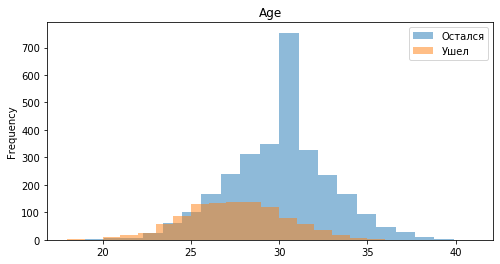

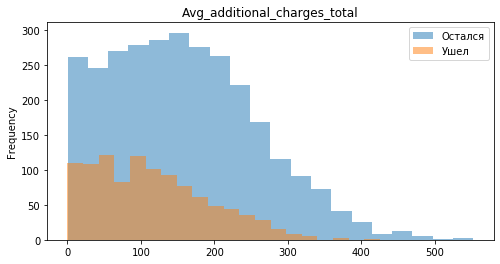

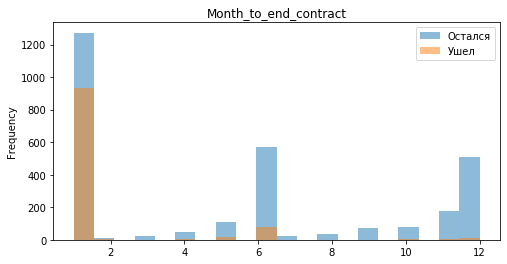

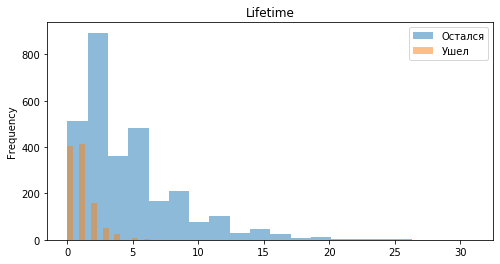

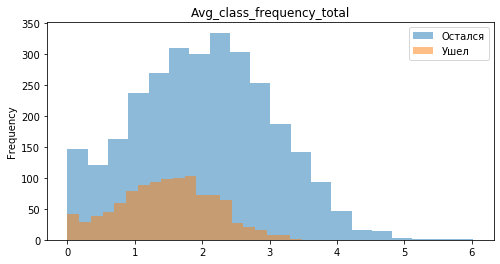

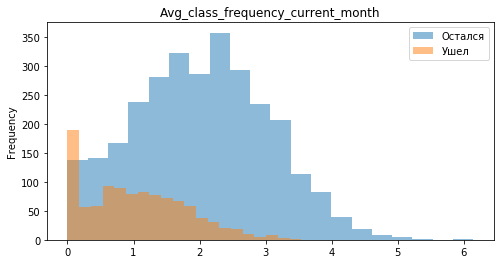

In [13]:
# Изучим гистограммы небинарных признаков
for column in col:
    df.groupby('Churn')[column].plot.hist(alpha=0.5, legend=True, bins=20, figsize=(8,4))
    plt.legend(['Остался', 'Ушел'])
    plt.title(column)
    plt.show()       

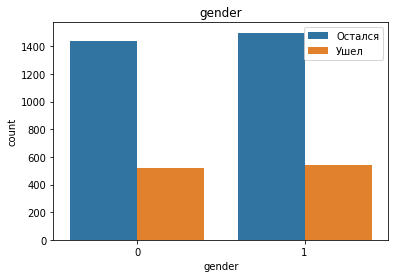

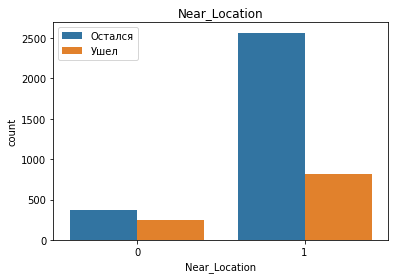

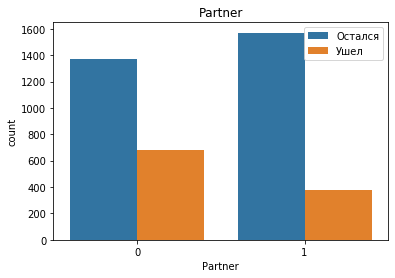

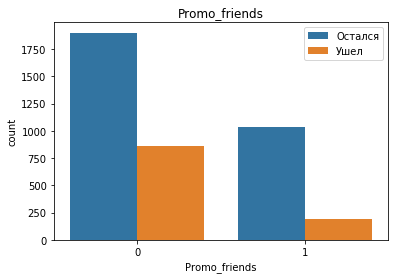

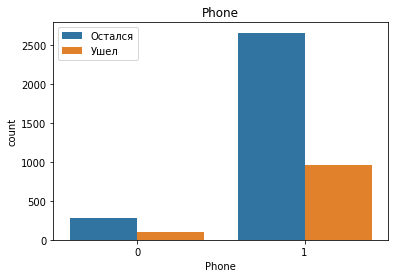

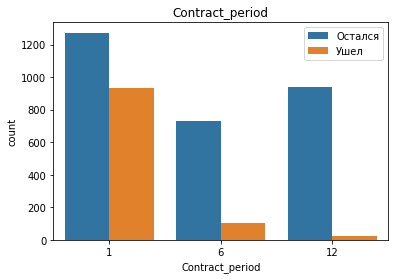

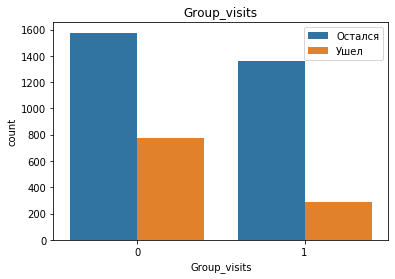

In [14]:
# визуализация бинарных признаков
for i in col_bin:
    sns.countplot(x=i, data=df, hue='Churn');
    plt.legend(['Остался', 'Ушел']);
    plt.title(i)
    plt.show();

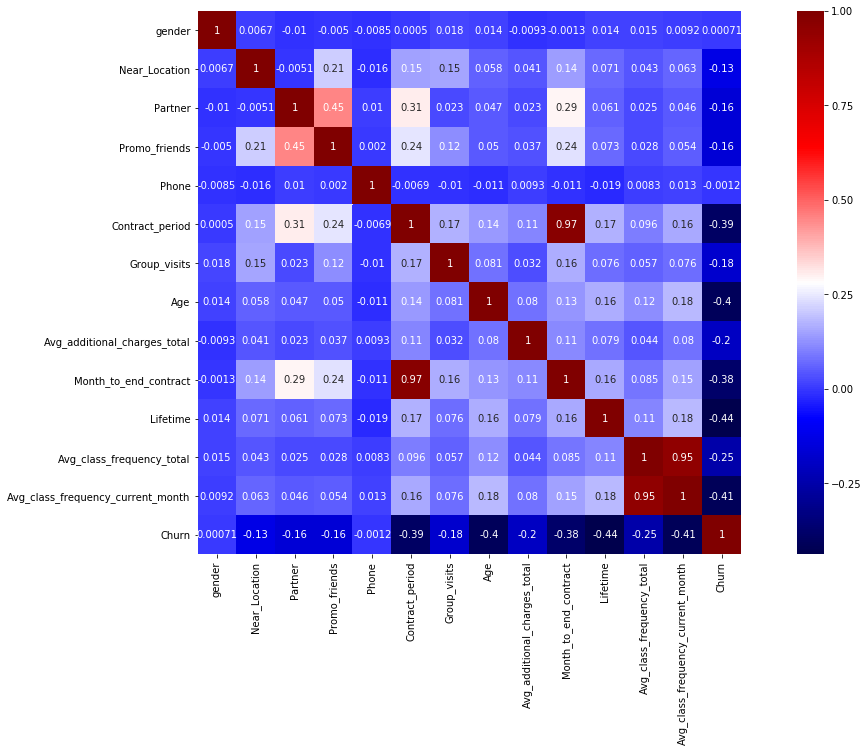

In [15]:
# построим матрицу корреляций
corr=df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, square=True, cmap="seismic");

## Вывод:

- данные хорошо подготовлены, дубликатов и пропусков нет
- гисторгаммы показывают следующие закономерности:
        - пол не влияет на отток, количество мужчин и женщин в клубах примерно одинаковое
        - в целом клубом польжуются те, кто близко живет
        - с партнером, люди уходят меньше
        - те тко приходят с другом уходят реже(см предыдущий пункт)
        - посетители групповых занятий уходят реже
        - более взрослые клиенты уходят меньше

- матрица корреляций показывает следующие сильные прямые зависимости:
       -  срок до окончания текущего действующего абонемента и длительность текущего действующего абонемента 
       -  средняя частота посещений в неделю за предыдущий месяц и  средняя частота посещений в неделю за все время с начала действия абонемента
       
- Существенные линейные корреляци между признаками и целевой переменной не обнаружены. Самая сильная зависимость: Отток-лайфтайм (Коэффициент корреляции Пирсона = -0.44), т.е более старые клиенты менее подвержены оттоку.
- Есть признаки с 0 корреляцией с целевой переменной: пол и телефон.
       
При работе с некоторыми моделями стоит учитывать наличие сильно коррелирующх признаков.

# Модель прогнозирования оттока клиентов

In [16]:
# отделим признаки от целевого значения
X = df.drop('Churn', axis=1)
y = df['Churn']

In [17]:
# разделим выборку на тестовую и валидационную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
# стандартизируем выборки
scaler =StandardScaler()
X_train_st= scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [19]:
# модель логистической регрессии
model =LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train_st, y_train);
predictions = model.predict(X_test_st);

print('accuracy:{:.2f} precision:{:.2f} recall:{:.2f}'.format(accuracy_score(y_test, predictions),
                                                              precision_score(y_test, predictions),
                                                              recall_score(y_test, predictions)))

accuracy:0.92 precision:0.85 recall:0.83


In [20]:
# классификатор рандомный лес
warnings.filterwarnings("ignore")
    
model =RandomForestClassifier(random_state=0)
model.fit(X_train_st, y_train);
predictions = model.predict(X_test_st);
    
print('accuracy:{:.2f} precision:{:.2f} recall:{:.2f}'.format(accuracy_score(y_test, predictions),
                                                              precision_score(y_test, predictions),
                                                              recall_score(y_test, predictions)))

accuracy:0.91 precision:0.83 recall:0.78


## Улучшаем модель

In [21]:
X = df.drop(['Churn', 'gender', 'Phone'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=X['Near_Location'])
scaler =StandardScaler()
X_train_st= scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [22]:
# модель логистической регрессии
model =LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced')
model.fit(X_train_st, y_train);
predictions = model.predict(X_test_st );

print('accuracy:{:.2f} precision:{:.2f} recall:{:.2f}'.format(accuracy_score(y_test, predictions),
                                                              precision_score(y_test, predictions),
                                                              recall_score(y_test, predictions)))

accuracy:0.94 precision:0.85 recall:0.94


Базовая модель

accuracy:0.92 precision:0.85 recall:0.83
            
Удален пол и телефон + stratify=X['Near_Location']             
accuracy:0.94 precision:0.94 recall:0.84  
            
Удален пол и телефон + stratify=X['Near_Location'] + class_weight='balanced'                
accuracy:0.94 precision:0.85 recall:0.94        

## Вывод:

Доля правильных ответов(accuracy), точность (precision) и полнота (recall) выше у модели логистической регрессии, при этом метрика полнота, значительно выше.

Модель LogisticRegression лучше предсказывает отток клиентов.



# Кластеризация клиентов

In [23]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [24]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [25]:
# таблица «связок» между признаками
linked = linkage(X_sc, method = 'ward') 

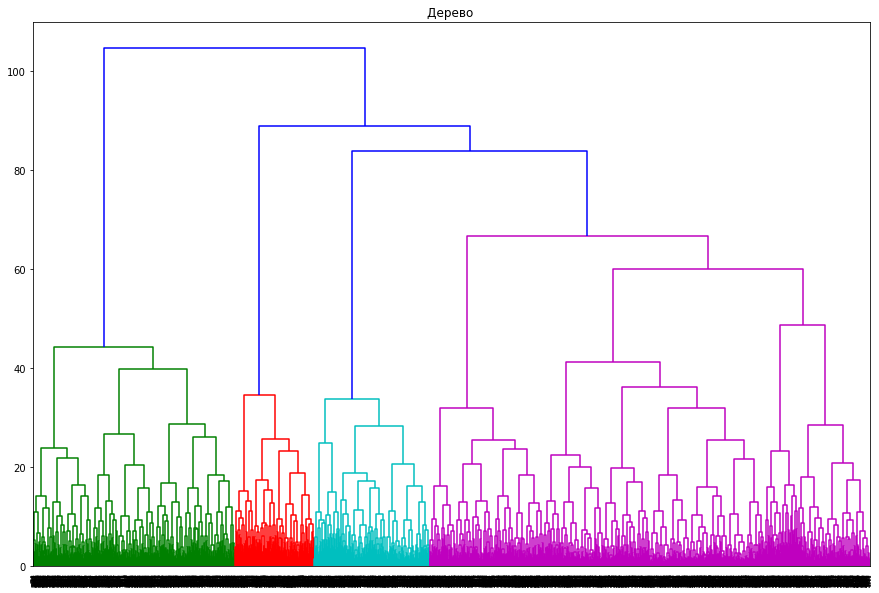

In [26]:

# Визуализация дендограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дерево ')
plt.show() 


Рекомендуемое моделью чисто кластеров -4

In [27]:
# обучим модель кластеризации 
km = KMeans(n_clusters=5, random_state=0)

labels = km.fit_predict(X_sc)


In [28]:
# посмотрим на средние значения признаков для кластеров
X['cluster'] = labels

X.groupby(['cluster']).mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
cluster,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473


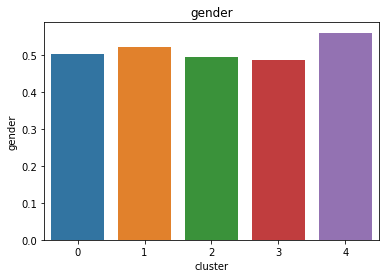

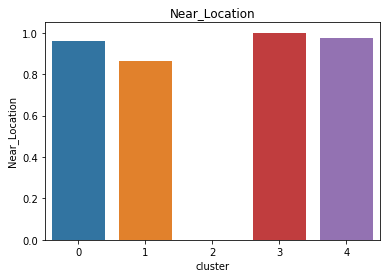

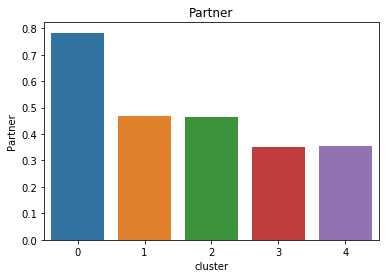

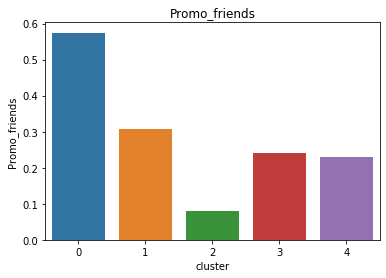

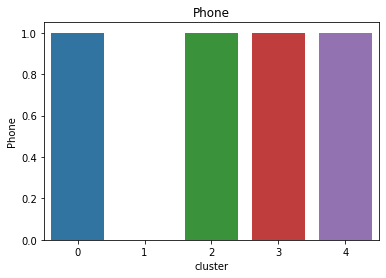

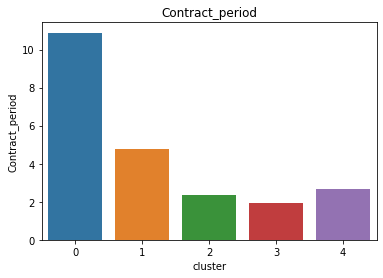

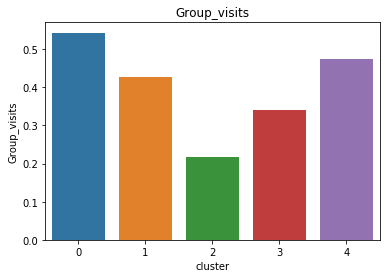

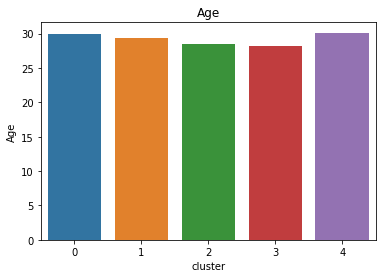

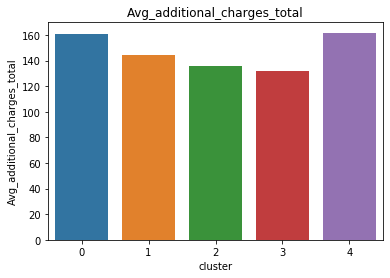

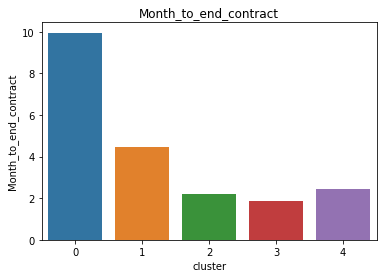

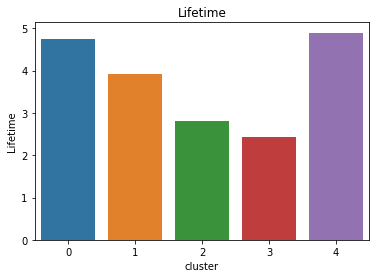

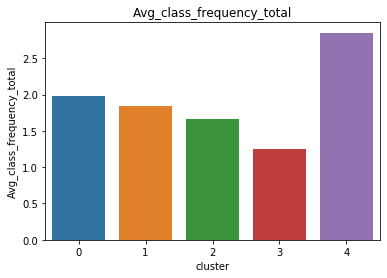

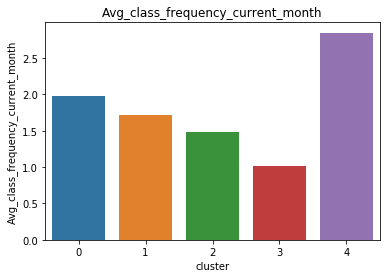

In [29]:

for i in X.groupby('cluster').mean().reset_index().drop('cluster', axis=1):
    sns.barplot(x='cluster', y=i, data=X.groupby('cluster').mean().reset_index());
    plt.title(i)
    plt.show();

In [30]:
df['cluster'] = labels


In [31]:
df.groupby('cluster')['Churn'].sum()

cluster
0     28
1    103
2    224
3    649
4     57
Name: Churn, dtype: int64

In [32]:
# Доля оттока по каждому кластеру
df.groupby('cluster')['Churn'].mean()*100

cluster
0     2.769535
1    26.753247
2    44.356436
3    51.426307
4     6.810036
Name: Churn, dtype: float64

**Особенности каждого кластера:**

0 низкая вероятность оттока, очень много партнеров, по акции с другом, дольше всего до конца абонемента, групповые занятия, дольше всего до конца абонемента, старые клиенты

1 не указали телефон, средняя группа, ничем не выделяющаяся

2 большая вероятность оттока, все находятся далеко от клуба, без акции с другом, меньше всего до конца абонемента, новые клиенты

3 самая большая вероятность оттока, все находятся близко к клубу, меньше всего партнеров, меньше всего до конца абонемента, новые клиенты

4 низкая вероятность оттока, меньше всего партнеров, групповые занятия, старые клиенты, самая лучшая посещаемость

# Вывод:

5 групп слишком много для интерпритации в данном случае, я, бы рекомендовал разделть всех на 3 группы и сконцентрировался на средней сомневающейся группе.

Рекомендую:

    - Активнее продвигать групповые занятия
    - Сдвинуть акцент на долгосрочные абонементы(Больше мотивации ходить и пратить деньги на доп услуги)
    - Важным критерием является наличие партнера, нужны акции и спец предложения типа приведи друга или занятия с тренером.
    - Практиковать индивидуальные предложения для сомневающихся групп.
